# Deep Dreams (with PyTorch)

This notebook demonstrates how to use the [PyTorch](https://pytorch.org/) neural network framework to produce "dream" visuals shown in the [Google Research blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

In [1]:
from collections.abc import Callable

from PIL import Image
from IPython.display import clear_output, display

import torch
import torch.nn as nn
import pytorch_caffe_models
import torchvision
from torchvision.models import feature_extraction
from torchvision import transforms as T
from torchvision.transforms import functional as FT

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

## Model

In [3]:
model, transform = pytorch_caffe_models.googlenet_bvlc()
model = model.to(DEVICE)
model = model.eval()
model = model.requires_grad_(False)

## Normalization

In [4]:
preprocess = T.Compose([
    T.ConvertImageDtype(torch.float32)
])

In [5]:
deprocess = T.Compose([
    T.ConvertImageDtype(torch.uint8)
])

## Producing Dreams

Making the "dream" images is very simple. Essentially it is just a gradient ascent process that tries to maximize the L2 norm of activations of a particular DNN layer. Here are a few simple tricks that we found useful for getting good images:
* offset image by a random jitter
* normalize the magnitude of gradient ascent steps
* apply ascent across multiple scales (octaves)

First we implement a basic gradient ascent step function, applying the first two tricks:

In [6]:
def objective_l2(features: torch.Tensor) -> None:
    loss = 0.5 * torch.sum(features**2)
    loss.backward()

In [7]:
def make_step(extractor: nn.Module, transform: Callable[[torch.Tensor], torch.Tensor], input: torch.Tensor,
              do_loss: Callable[[torch.Tensor], torch.Tensor], step_size: float, jitter: int | None, clip: bool) -> torch.Tensor:
    if jitter:
        rx, ry = torch.randint(-jitter, jitter+1, (2,))
        input.data = torch.roll(input, shifts=(rx, ry), dims=(2, 3))

    features = extractor(transform(input))
    features = features['out']
    
    do_loss(features)
    grad = input.grad

    input.data += step_size/grad.abs().mean() * grad

    # zero gradient
    input.grad.zero_()

    # unshift image
    if jitter:
        input.data = torch.roll(input, shifts=(-rx, -ry), dims=(2, 3))

    # clip input
    if clip:
        input.data = torch.max(torch.min(input, torch.tensor(1.0)), torch.tensor(0.0))

    return input

Next we implement an ascent through different scales. We call these scales "octaves".

In [8]:
def deepdream(model: nn.Module, transform: Callable, base_img: torch.Tensor, end: str, do_loss: Callable[[torch.Tensor], torch.Tensor],
              num_iter: int, num_octaves: int, octave_scale: float, step_size: float, jitter: int | None, clip: bool) -> torch.Tensor:
    base_img = preprocess(base_img)
    original_size = torch.tensor(base_img.shape[-2:])
    
    extractor = feature_extraction.create_feature_extractor(model, {end: 'out'})

    # prepare base images for all octaves, from largest to smallest
    octaves = []
    for i in range(num_octaves):
        octave_size = torch.round(original_size / (octave_scale ** i)).to(dtype=torch.int64)
        octave_img = FT.resize(base_img, size=octave_size, antialias=True)
        octaves.append(octave_img)
        
    # allocate image for network-produced details
    detail = torch.zeros_like(octaves[-1])
    
    for octave, octave_base in enumerate(octaves[::-1]):
        if octave > 0:
            # upscale details from previous octave
            h, w = octave_base.shape[-2:]
            detail = FT.resize(detail, size=[h, w], antialias=True)
        
        # prepare input image
        img = octave_base.unsqueeze(dim=0)
        img = img + detail
        img = img.to(DEVICE)
        img.requires_grad = True

        for i in range(num_iter):
            img = make_step(extractor, transform, img, do_loss, step_size, jitter, clip)
            
            # visualization
            vis = img.squeeze(dim=0)
            vis = deprocess(vis)
            vis = vis.permute((1, 2, 0))
            display(Image.fromarray(vis.cpu().numpy()))
            print(octave, i, end, vis.shape)
            clear_output(wait=True)
        
        # extract details produced on the current octave
        detail = img.data - octave_base
    
    # returning the resulting image
    img = img.squeeze(dim=0)
    return deprocess(img)

Now we are ready to let the neural network reveal its dreams! Let's take a [cloud image](https://commons.wikimedia.org/wiki/File:Appearance_of_sky_for_weather_forecast,_Dhaka,_Bangladesh.JPG) as a starting point:

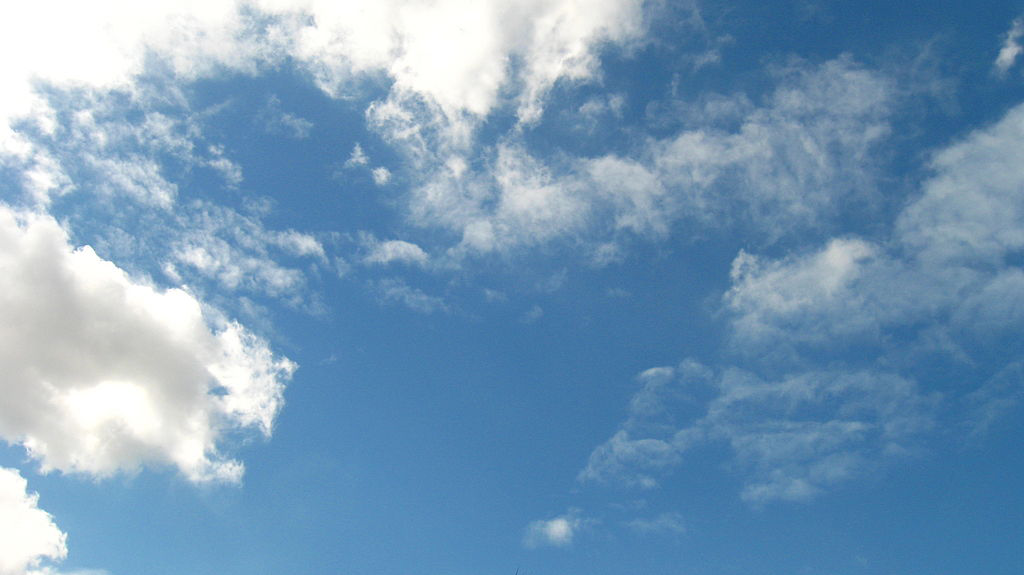

In [9]:
file = 'sky1024px.jpg'

img = torchvision.io.image.read_image(file)
img = img[:3, :, :]  # RGBA -> RGB
img = img.to(DEVICE)
Image.fromarray(img.cpu().permute((1, 2, 0)).numpy(), mode='RGB')

Set hyperparameters
- Note that the caffe model operates in $[0..255]$ and the PyTorch model operates in $[0..1]$ therefore we need to divide the `step_size` $1.5$ by $255$.

In [10]:
num_iter = 10
num_octaves = 4
octave_scale=1.4
step_size = 0.005882353  # 1.5 / 255
jitter = 32
clip = True

Running the next code cell starts the detail generation process. You may see how new patterns start to form, iteration by iteration, octave by octave.

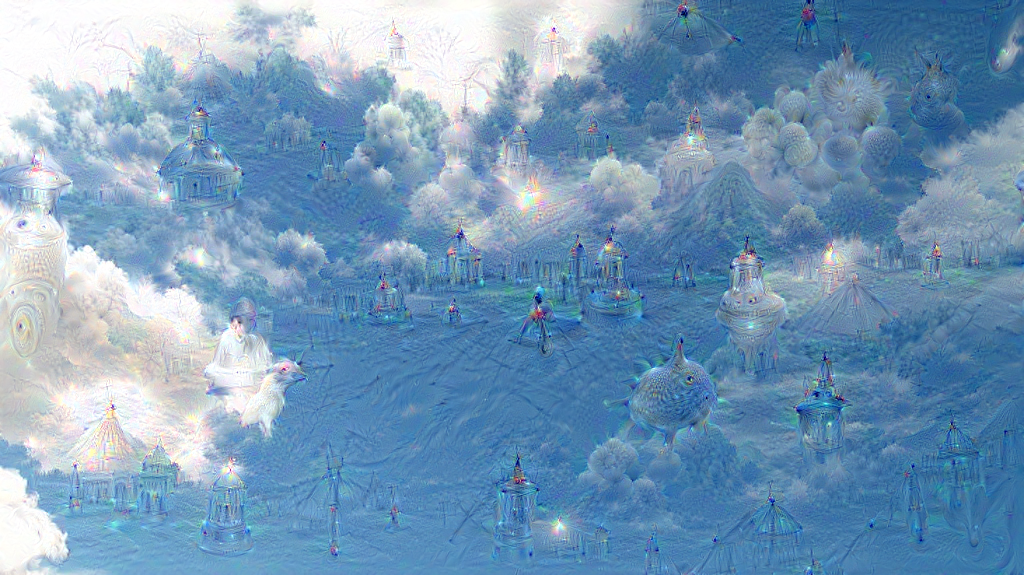

3 9 inception_4c torch.Size([575, 1024, 3])


In [11]:
_ = deepdream(model, transform, img, 'inception_4c', objective_l2, num_iter, num_octaves, octave_scale, step_size, jitter, clip)

The complexity of the details generated depends on which layer's activations we try to maximize. Higher layers produce complex features, while lower ones enhance edges and textures, giving the image an impressionist feeling:

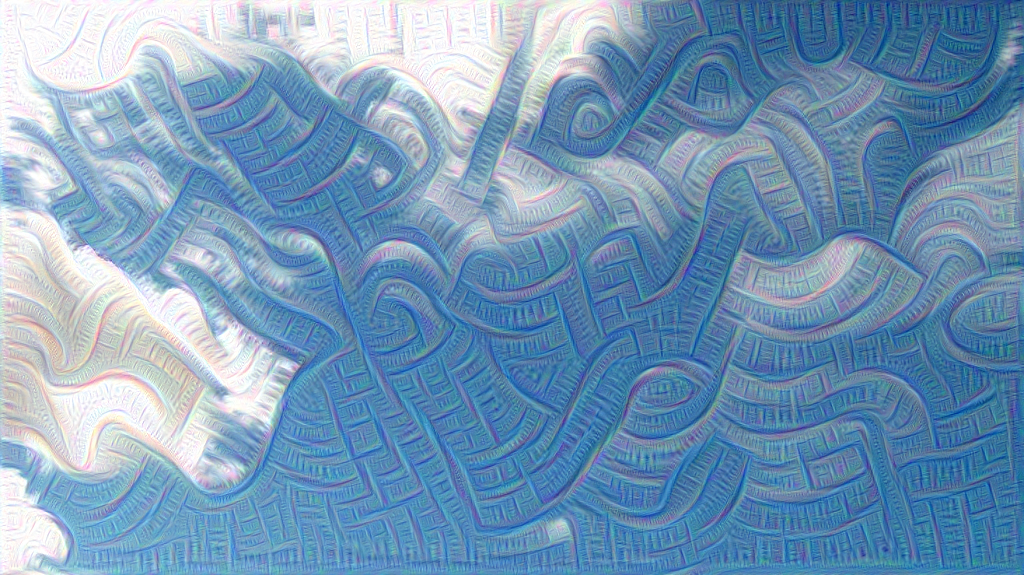

3 9 inception_3b.conv_5x5_reduce torch.Size([575, 1024, 3])


In [12]:
_ = deepdream(model, transform, img, 'inception_3b.conv_5x5_reduce', objective_l2, num_iter, num_octaves, octave_scale, step_size, jitter, clip)

We encourage readers to experiment with layer selection to see how it affects the results. Execute the next code cell to see the list of different layers. `eval_nodes` lists available layers, e.g. `inception_4c` or `inception_3b.conv_5x5_reduce`: You can modify the `make_step` function to make it follow some different objective, say to select a subset of activations to maximize, or to maximize multiple layers at once. There is a huge design space to explore!

In [ ]:
train_nodes, eval_nodes = feature_extraction.get_graph_node_names(model)
eval_nodes

What if we feed the `deepdream` function its own output, after applying a little zoom to it? It turns out that this leads to an endless stream of impressions of the things that the network saw during training. Some patterns fire more often than others, suggestive of basins of attraction.

We will start the process from the same sky image as above, but after some iteration the original image becomes irrelevant; even random noise can be used as the starting point.

In [14]:
!mkdir -p frames
frame = img
frame_i = 0

In [ ]:
s = 1.05  # scale coefficient

h, w = frame.shape[-2:]
hn, wn = [round(s * h), round(s * w)]

for i in range(100):
    frame = deepdream(model, transform, frame, 'inception_4c', objective_l2, num_iter, num_octaves, octave_scale, step_size, jitter, clip)
    Image.fromarray(frame.permute((1, 2, 0)).cpu().numpy()).save(f'frames/{frame_i:04d}.jpg')

    frame = FT.resize(frame, size=[hn, wn], antialias=True)
    frame = FT.center_crop(frame, output_size=[h, w])
    frame_i += 1

Be careful running the code above, it can bring you into very strange realms!

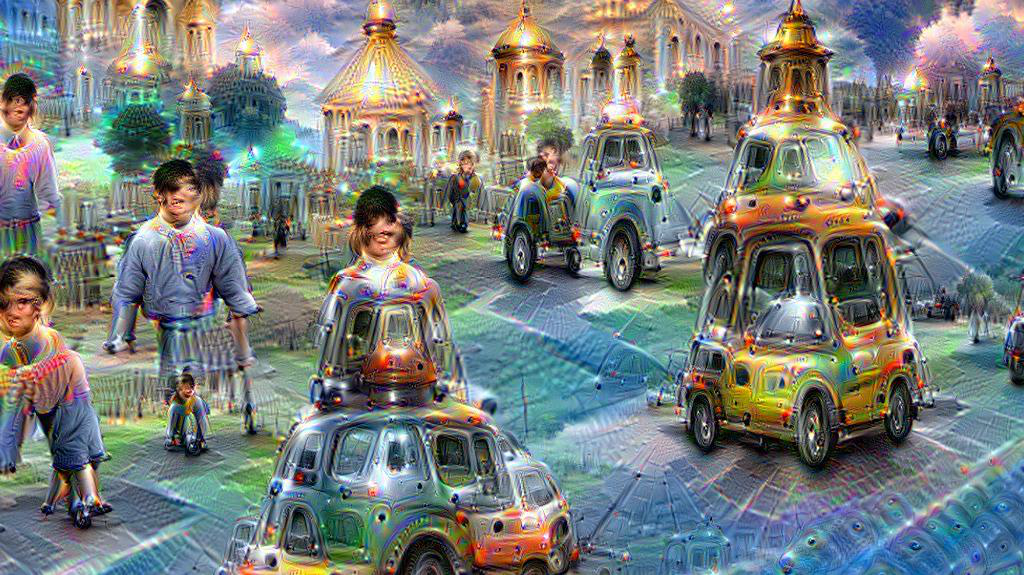

In [15]:
Image.open('frames/0029.jpg')

## Controlling dreams

The image detail generation method described above tends to produce some patterns more often the others. One easy way to improve the generated image diversity is to tweak the optimization objective. Here we show just one of many ways to do that. Let's use one more input image. We'd call it a "*guide*".

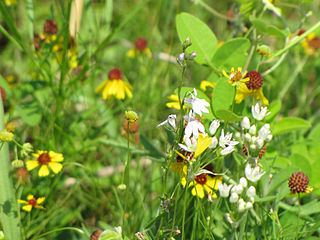

In [16]:
guide = torchvision.io.image.read_image('flowers.jpg')
guide = guide[:3, :, :]  # RGBA -> RGB
guide = guide.unsqueeze(dim=0)
guide = guide.to(DEVICE)
Image.fromarray(guide.squeeze(dim=0).permute((1, 2, 0)).numpy(), mode='RGB')

Note that the neural network we use was trained on images downscaled to 224x224 size. So high resolution images might have to be downscaled, so that the network could pick up their features. The image we use here is already small enough.

Now we pick some target layer and extract guide image features.

In [17]:
extractor = feature_extraction.create_feature_extractor(model, {'inception_3b': 'out'})
guide_features = extractor(transform(preprocess(guide)))
guide_features = guide_features['out']
guide_features.shape

torch.Size([1, 480, 30, 40])

Instead of maximizing the L2-norm of current image activations, we try to maximize the dot-products between activations of current image, and their best matching correspondences from the guide image.

In [18]:
def objective_guide(features: torch.Tensor) -> torch.Tensor:
    x = features.squeeze(dim=0)
    y = guide_features.squeeze(dim=0)
    
    ch = x.shape[0]

    x = x.reshape(ch, -1)
    y = y.reshape(ch, -1)

    A = x.T.matmul(y)  # compute the matrix of dot-products with guide features
    diff = y[:, A.argmax(1)]  # select ones that match best
    
    x.backward(diff)

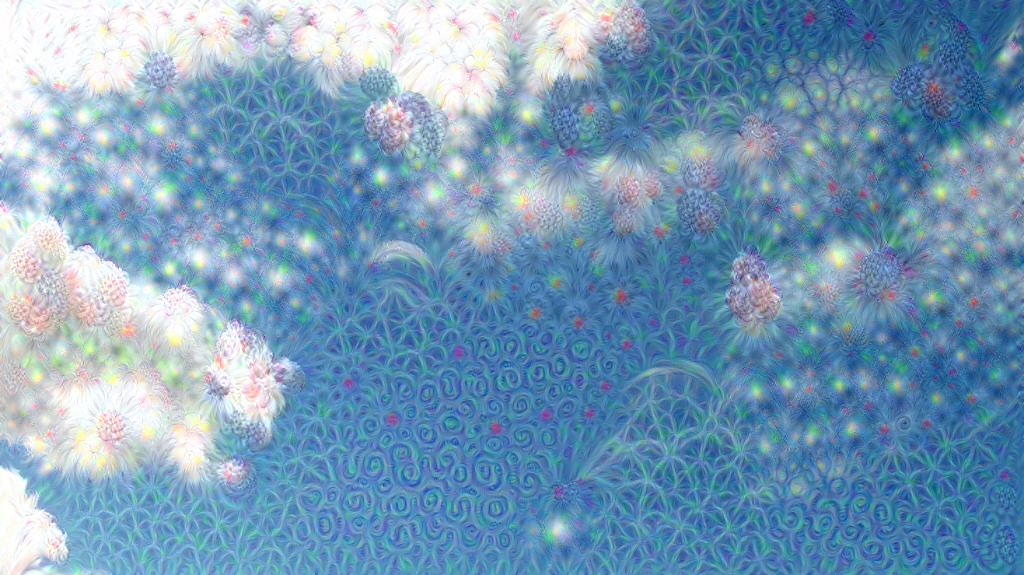

3 9 inception_3b torch.Size([575, 1024, 3])


In [19]:
_ = deepdream(model, transform, img, 'inception_3b', objective_guide, num_iter, num_octaves, octave_scale, step_size, jitter, clip)

This way we can affect the style of generated images without using a different training set.